<h1>Modeling and Prediction</h1>
On the West Nile Virus data set

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats

sns.set_style('whitegrid')

In [2]:
#loading cleaned data
X = pd.read_pickle('./data/X2.pkl')
y = pd.read_pickle('./data/y.pkl')



In [3]:
# mistakenly, thought that the train_test_split was done for me. It was not, the test set is for the kaggle competition
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123)

<h2>Random Forest Classifier</h2>
Random Forest Classifier is a great ensemble method which I will look into first with a Random Search CV. The driving metric for analysis is roc_auc. This data set is heavily class biased -- there are few west nile virus sightings compared to the observations as a whole. The area under the roc curve is relatively good at handling this sort of imbalance.

***Building Pipeline***

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score
from scipy.stats import truncnorm, uniform


In [5]:
pipe = make_pipeline( 
    StandardScaler(), 
    RandomForestClassifier()
)

In [6]:
pipe.get_params().keys()


dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'randomforestclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_impurity_split', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclassifier__warm_start'])

In [7]:
params = {'randomforestclassifier__n_estimators': np.arange(50,2000),
         'randomforestclassifier__max_depth' :  np.arange(2,20)}

rf_rand = RandomizedSearchCV(pipe,param_distributions=params,cv=5, n_jobs=-1, scoring = 'roc_auc',n_iter=10,
                            random_state = 42, verbose= 10)

In [8]:
rf_rand.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   40.0s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   41.4s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   42.0s finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'randomforestclassifier__n_estimators': array([  50,   51,   52, ..., 1997, 1998, 1999])},
                   random_state=42, scoring='roc_auc', verbose=10)

***Looking at results from the random search***

In [9]:
rf_rand.best_params_

{'randomforestclassifier__n_estimators': 1300,
 'randomforestclassifier__max_depth': 10}

In [10]:
rf_res = pd.DataFrame(rf_rand.cv_results_)


In [11]:
rf_res.sort_values('mean_test_score',axis=0, ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,9.898842,0.068317,0.707286,0.101503,1300,10,"{'randomforestclassifier__n_estimators': 1300,...",0.812258,0.819232,0.829471,0.829112,0.773815,0.812778,0.020521,1
0,2.511614,0.032196,0.197249,0.006649,245,10,"{'randomforestclassifier__n_estimators': 245, ...",0.811757,0.816220,0.828316,0.830070,0.773379,0.811948,0.020505,2
6,3.335936,0.175659,0.246179,0.050726,473,10,"{'randomforestclassifier__n_estimators': 473, ...",0.810136,0.817231,0.826911,0.831460,0.772957,0.811739,0.020765,3
5,4.286522,0.155373,0.347968,0.067023,562,13,"{'randomforestclassifier__n_estimators': 562, ...",0.811606,0.816876,0.826631,0.827239,0.767603,0.809991,0.022005,4
2,12.887732,0.172624,0.800347,0.053615,1584,7,"{'randomforestclassifier__n_estimators': 1584,...",0.800506,0.803529,0.819762,0.836207,0.772155,0.806432,0.021367,5
3,3.509324,0.214340,0.272909,0.038146,465,5,"{'randomforestclassifier__n_estimators': 465, ...",0.794591,0.777378,0.806260,0.832198,0.761647,0.794415,0.024215,6
9,2.341675,0.618864,0.114068,0.043611,533,3,"{'randomforestclassifier__n_estimators': 533, ...",0.803339,0.742114,0.783616,0.818980,0.742561,0.778122,0.031294,7
1,6.376066,0.049483,0.407873,0.025757,910,2,"{'randomforestclassifier__n_estimators': 910, ...",0.804328,0.726712,0.765189,0.800035,0.722297,0.763712,0.034801,8
8,4.071468,0.311629,0.300236,0.053394,819,2,"{'randomforestclassifier__n_estimators': 819, ...",0.803256,0.721804,0.766192,0.799220,0.724333,0.762961,0.035028,9
7,8.481484,0.072459,0.709436,0.067668,1735,2,"{'randomforestclassifier__n_estimators': 1735,...",0.805665,0.720872,0.765515,0.801724,0.716269,0.762009,0.038157,10


In [12]:
rf_rand.best_score_

0.8127775498158666

In [13]:
from sklearn.metrics import roc_curve

def roc_plot(e,x,y):
    """e is estimator, x is data and y is true value"""

    #predicting from model
    y_pred = e.predict_proba(x)[:,1]

    #finding curve
    fpr, tpr, t = roc_curve(y, y_pred)
    sns.lineplot(x=fpr,y=tpr)
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('Compute Receiver Operating Characteristic Curve')
    return pd.DataFrame({'fpr':fpr,'tpr':tpr,'threshold':t})

    


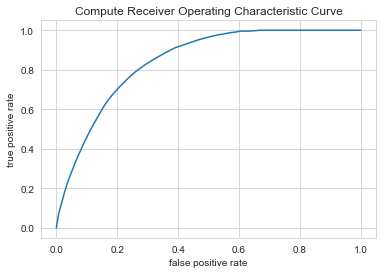

In [14]:
est = rf_rand.best_estimator_
c = roc_plot(est, X_train, y_train)

***Comparing to test set***

In [15]:
from sklearn.metrics import roc_auc_score


def test_comp(e):
    #predicting probability from test set
    y_pred = e.predict_proba(X_test)[:,1]
    
    
    r = np.round(roc_auc_score(y_test,y_pred),3)
    
    print('Evaluating the classifier on the test set, area under the roc curve is: ' +  
           '{}'.format(r))

test_comp(rf_rand.best_estimator_)

Evaluating the classifier on the test set, area under the roc curve is: 0.818


<h3>Random Forest first results</h3>

The classifier has decent performance. Let's see if with more parameters and a larger search I can improve the results even further.

In [16]:
params = {'randomforestclassifier__n_estimators': np.arange(50,2000),
         'randomforestclassifier__max_depth' :  np.arange(1,14)}

rf_rand_two = RandomizedSearchCV(pipe,param_distributions=params,cv=4, n_jobs=-1, scoring = 'roc_auc',n_iter=50,
                            random_state = 42, verbose = 10)
rf_rand_two.fit(X_train,y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2

RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
                                        'randomforestclassifier__n_estimators': array([  50,   51,   52, ..., 1997, 1998, 1999])},
                   random_state=42, scoring='roc_auc', verbose=10)

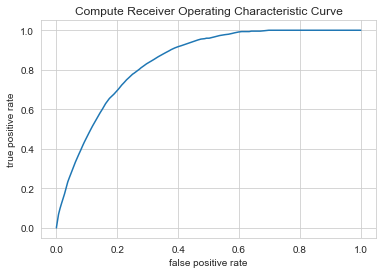

In [17]:
c = roc_plot(rf_rand_two.best_estimator_,X_train,y_train)


In [18]:
rf_rand_two.best_params_

{'randomforestclassifier__n_estimators': 473,
 'randomforestclassifier__max_depth': 9}

In [19]:
rf_rand_two.best_score_

0.8113187984875299

In [20]:
test_comp(rf_rand_two.best_estimator_)

Evaluating the classifier on the test set, area under the roc curve is: 0.816


In [21]:
rf_res = pd.DataFrame(rf_rand_two.cv_results_)
rf_res.sort_values('mean_test_score',axis=0, ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
14,2.489000,0.011167,0.212594,0.003051,473,9,"{'randomforestclassifier__n_estimators': 473, ...",0.813952,0.824299,0.833241,0.773783,0.811319,0.022721,1
33,9.980579,0.016702,0.677492,0.010670,1618,10,"{'randomforestclassifier__n_estimators': 1618,...",0.815488,0.823451,0.830391,0.773810,0.810785,0.021989,2
24,8.345735,0.078640,0.673350,0.003953,1489,11,"{'randomforestclassifier__n_estimators': 1489,...",0.816366,0.823209,0.829324,0.773582,0.810620,0.021870,3
35,7.878765,0.015090,0.704688,0.009098,1592,11,"{'randomforestclassifier__n_estimators': 1592,...",0.816012,0.824646,0.828234,0.773496,0.810597,0.021876,4
4,1.190135,0.009315,0.092595,0.004594,175,12,"{'randomforestclassifier__n_estimators': 175, ...",0.815803,0.824422,0.830952,0.770864,0.810510,0.023512,5
30,6.744145,0.047837,0.427197,0.008342,931,10,"{'randomforestclassifier__n_estimators': 931, ...",0.814421,0.823857,0.829899,0.773578,0.810439,0.021985,6
23,0.404872,0.015366,0.043468,0.004860,68,10,"{'randomforestclassifier__n_estimators': 68, '...",0.814623,0.823615,0.831130,0.772182,0.810388,0.022819,7
39,2.043129,0.009358,0.181073,0.002316,412,10,"{'randomforestclassifier__n_estimators': 412, ...",0.813966,0.823474,0.829675,0.774271,0.810346,0.021567,8
1,1.893156,0.015951,0.175556,0.024485,245,9,"{'randomforestclassifier__n_estimators': 245, ...",0.811652,0.821226,0.834067,0.774152,0.810274,0.022320,9
9,8.114312,0.057778,0.854939,0.004415,1300,9,"{'randomforestclassifier__n_estimators': 1300,...",0.814140,0.822302,0.831686,0.772857,0.810246,0.022462,10


<h3>Random Forest second results</h3>

More iterations in the random search yeilded an almost non-existent improvement. I will explore other classifiers before doing a thorough grid search within a more confined range, which will take a good amount of time. 

<h3>Random Forest Conclusions</h3>

The Random Forest Classifier performs well out of the gate with an auc of 0.863 on the training set and 0.894 on the test set. The optimal max depth appears to be either 5 or 6 and the optimal number of estimators is likely between 750 - 1750

<h2>Logistic Regression</h2>


In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:
pipe_lr = make_pipeline( 
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)

params = {'logisticregression__C': np.logspace(-2,6)}

#starting with few iterations, and narrowing the ranges afterwards
lr = RandomizedSearchCV(pipe_lr,param_distributions=params,cv=5, n_jobs=-1, verbose =10, 
                                 scoring = 'roc_auc',n_iter=20,random_state = 42)


In [24]:
lr.fit(X,y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0261s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1555s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('logisticregression',
                                              LogisticRegression(max_iter=1000))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'logisticregression__C': array([1.00000000e-02, 1.45634848e-02, 2.12095089e-02, 3.08884360e-02,
       4.49843267e-02, 6.55128557e-02, 9.54095476e-02, 1.38949549e-01,
       2.02358965e-0...
       3.72759372e+02, 5.42867544e+02, 7.90604321e+02, 1.15139540e+03,
       1.67683294e+03, 2.44205309e+03, 3.55648031e+03, 5.17947468e+03,
       7.54312006e+03, 1.09854114e+04, 1.59985872e+04, 2.32995181e+04,
       3.39322177e+04, 4.94171336e+04, 7.19685673e+04, 1.04811313e+05,
       1.52641797e+05, 2.22299648e+05, 3.23745754e+05, 4.71486636e+05,
       6.86648845e+05, 1.00000000e+06])},
                   random

In [25]:
lr.best_params_

{'logisticregression__C': 0.04498432668969444}

In [26]:
lr.best_score_

0.6487733039161612

<h3>ROC auc - Logistic Regression</h3>


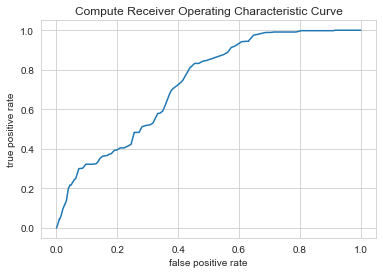

In [27]:
c = roc_plot(lr.best_estimator_,X_train,y_train)

<h3>Evaluating with test set</h3>

In [28]:
test_comp(lr.best_estimator_)

Evaluating the classifier on the test set, area under the roc curve is: 0.727


<h3>Logistic Regression Conclusions</h3>

The logistic regression results were considerably worse on the training set than random forest. But surprisingly close for the test set. I prefer the random forest classifier, and I expect that on a different test set, I would see different results. 

<h2>KNN </h2>

I don't expect KNN to give better results due to the high-dimensionality of the feature space. I expect PCA to be necessary, though I will try it without first. 

In [29]:
from sklearn.neighbors import KNeighborsClassifier

pipe_knn = make_pipeline( 
    StandardScaler(),
    KNeighborsClassifier(weights='distance')
)

params = {'kneighborsclassifier__n_neighbors': np.arange(1,200)}
    

#starting with few iterations, and narrowing the ranges afterwards
knn = RandomizedSearchCV(pipe_knn,param_distributions=params,cv=5, n_jobs=-1, verbose =10, 
                                 scoring = 'roc_auc',n_iter=200,random_state = 42)

knn.fit(X_train,y_train)

Fitting 5 folds for each of 199 candidates, totalling 995 fits


/Users/jon/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 199 is smaller than n_iter=200. Running 199 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1381s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 178

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('kneighborsclassifier',
                                              KNeighborsClassifier(weights='distance'))]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'kneighborsclassifier__n_neighbors': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,...
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 

In [30]:
knn.best_params_

{'kneighborsclassifier__n_neighbors': 164}

In [31]:
knn.best_score_

0.8091892545413615

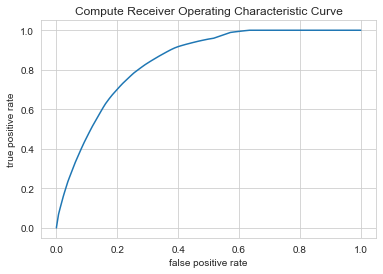

In [32]:
c = roc_plot(knn.best_estimator_,X_train,y_train)

In [33]:
test_comp(knn.best_estimator_)

Evaluating the classifier on the test set, area under the roc curve is: 0.811


Knn performed better than expected, with a max aoc of 0.827 for train and similar for test. Let's see if PCA improves

In [34]:
from sklearn.decomposition import PCA

pipe_knn = make_pipeline( 
    StandardScaler(),
    PCA(),
    KNeighborsClassifier(weights='distance')
)

params = {'pca__n_components' : np.arange(2,X.shape[1]),
          'kneighborsclassifier__n_neighbors': np.arange(50,250)}
    

#starting with few iterations, and narrowing the ranges afterwards
knn = RandomizedSearchCV(pipe_knn,param_distributions=params,cv=5, n_jobs=-1, verbose =10, 
                                 scoring = 'roc_auc',n_iter=200,random_state = 42)

knn.fit(X_train,y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0458s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 314 tas

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('pca', PCA()),
                                             ('kneighborsclassifier',
                                              KNeighborsClassifier(weights='distance'))]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'kneighborsclassifier__n_neighbors': array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  8...
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
       206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
       219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
       232, 233, 234, 235, 236

In [35]:
knn.best_params_

{'pca__n_components': 3, 'kneighborsclassifier__n_neighbors': 238}

In [36]:
knn.best_score_

0.8132308304746545

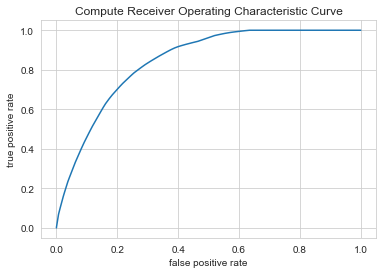

In [37]:
c = roc_plot(knn.best_estimator_,X_train,y_train)

<h3>Evaluating with test set</h3>

In [38]:
test_comp(knn.best_estimator_)

Evaluating the classifier on the test set, area under the roc curve is: 0.812


<h3>KNN Conclusions</h3>

PCA did not improve things by much, if at all. It's certainly not worth it to lose feature importances. 

<h2>SVC</h2>

SVC is supposedly good in high dimension data, and the set I have is relatively high dimension. 

In [39]:
from sklearn.svm import SVC

pipe_svc = make_pipeline( 
    StandardScaler(),
    SVC(probability=True)
)

params = {'svc__C': np.logspace(-5,5)}
    

#starting with few iterations, and narrowing the ranges afterwards
svc = RandomizedSearchCV(pipe_svc,param_distributions=params,cv=5, n_jobs=-1, verbose =10, 
                                 scoring = 'roc_auc',n_iter=10,random_state = 42)

svc.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.6s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    9.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.8s finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svc', SVC(probability=True))]),
                   n_jobs=-1,
                   param_distributions={'svc__C': array([1.00000000e-05, 1.59985872e-05, 2.55954792e-05, 4.09491506e-05,
       6.55128557e-05, 1.04811313e-04, 1.67683294e-04, 2.68269580e-04,
       4.29193426e-04, 6.86648845e-04, 1.09854114e-03, 1.75751062e-03,
       2.811...
       5.17947468e+00, 8.28642773e+00, 1.32571137e+01, 2.12095089e+01,
       3.39322177e+01, 5.42867544e+01, 8.68511374e+01, 1.38949549e+02,
       2.22299648e+02, 3.55648031e+02, 5.68986603e+02, 9.10298178e+02,
       1.45634848e+03, 2.32995181e+03, 3.72759372e+03, 5.96362332e+03,
       9.54095476e+03, 1.52641797e+04, 2.44205309e+04, 3.90693994e+04,
       6.25055193e+04, 1.00000000e+05])},
                   random_state=42, scoring='roc_auc', verbos

In [40]:
svc.best_params_

{'svc__C': 13.257113655901108}

In [41]:
svc.best_score_

0.628167241855859

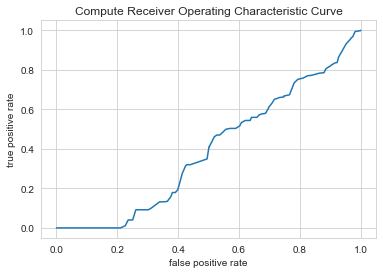

In [42]:
c = roc_plot(svc.best_estimator_,X_train,y_train)

<h3>Evaluating with test set</h3>

In [43]:
test_comp(svc.best_estimator_)

Evaluating the classifier on the test set, area under the roc curve is: 0.444


<h3>SVC Conclusions</h3>

SVC clearly performs worse

<h1>Choosing a classifier</h1>

Two models stand out as options to ultimately choose -- Random Forest and KNN. The random forest model has a feature importance attribute, which is a great piece of data, so I will choose it. 

In [44]:
from sklearn.model_selection import GridSearchCV

pipe_rf = make_pipeline( 
    StandardScaler(), 
    RandomForestClassifier()
)

params = {'randomforestclassifier__n_estimators': np.arange(750,2000,50),
          'randomforestclassifier__max_depth' :  np.arange(4,10)}

rf = GridSearchCV(pipe,param_grid=params,cv=5, n_jobs=-1, scoring = 'roc_auc',verbose=10)

rf.fit(X_train,y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': array([4, 5, 6, 7, 8, 9]),
                         'randomforestclassifier__n_estimators': array([ 750,  800,  850,  900,  950, 1000, 1050, 1100, 1150, 1200, 1250,
       1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800,
       1850, 1900, 1950])},
             scoring='roc_auc', verbose=10)

In [45]:
rf.best_params_

{'randomforestclassifier__max_depth': 9,
 'randomforestclassifier__n_estimators': 750}

***Evaluating Performance***

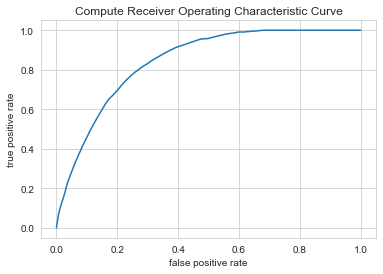

In [73]:
c = roc_plot(rf.best_estimator_,X_train,y_train)

In [47]:
test_comp(rf.best_estimator_)

Evaluating the classifier on the test set, area under the roc curve is: 0.815


In [78]:
df_t = c[c.tpr > 0.9].sort_values('threshold',ascending=False)

thresh = df_t.iloc[0,2]

***Looking at feature importance***

In [48]:
r = rf.best_estimator_
imp = r.steps[1][1].feature_importances_

<AxesSubplot:xlabel='importance', ylabel='feature'>

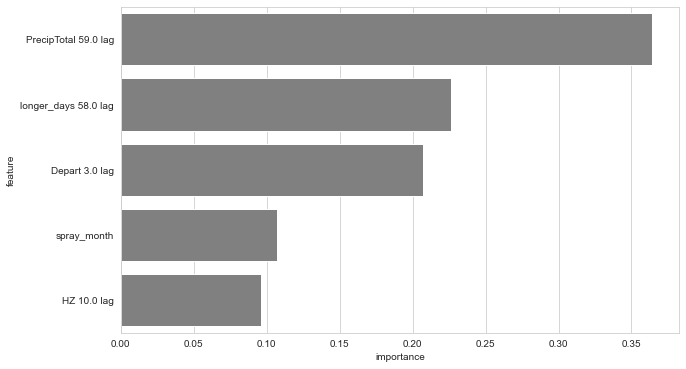

In [49]:
ax = plt.figure(figsize=(10,6))

i = pd.DataFrame({'feature':X_test.columns,'importance':imp}).sort_values('importance',ascending=False)

sns.barplot(data=i,y='feature',x='importance',orient='h',color='gray')

***Recall***

In [63]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

def test_comp_recall(e):
    #predicting probability from test set
    y_pred = e.predict(X_test)
    #deciding membership

    r = np.round(recall_score(y_test,y_pred),3)
    p = np.round(precision_score(y_test,y_pred),3)
    print('Evaluating the classifier on the test set, the recall is: ' +  
          '{}, and the precision is: {}'.format(r,p))


from sklearn.metrics import precision_recall_curve

def pr_curve(e,x,y):
    """e is estimator, x is data and y is true value"""

    #predicting from model
    y_pred_rf = e.predict_proba(x)

    #finding curve
    p, r, t = precision_recall_curve(y.to_numpy(),y_pred_rf[:,1])
    sns.lineplot(x=p,y=r)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    return pd.DataFrame({'precision':p[:-1],'recall':r[:-1],'threshold':t})

    


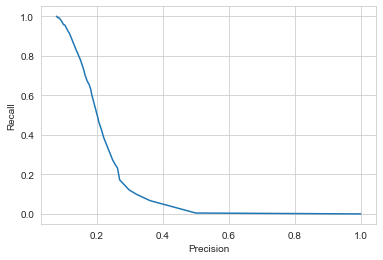

In [64]:
c = pr_curve(rf.best_estimator_,X_train,y_train)

Text(34.0, 0.5, 'True')

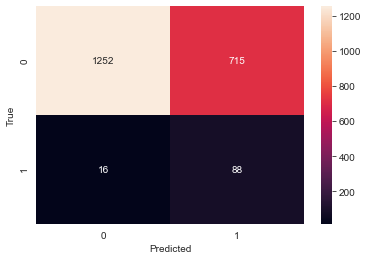

In [85]:
from sklearn.metrics import confusion_matrix

clf = rf_rand.best_estimator_
y_pred = clf.predict_proba(X_test)[:,1]
y_pred = (y_pred >= thresh).astype('int')

sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')

<h1>Conclusions</h1>
